In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from model.MinAggGNN import MinAggGNN
import matplotlib.pyplot as plt

device = torch.device('cuda')
L = 2
m = 2
epochs = 20000
eta = 0.001

model = MinAggGNN(1, 8, L, 1, edge_dim = 1)
state_dict = torch.load('model_progress/bellman_ford/model_final.pt')
model.load_state_dict(state_dict)
model.eval()
model.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


MinAggGNN(1, 1, num_layers=2)

In [14]:
from MINAR.ComputationGraph import ComputationGraph, Circuit
from model.CustomLosses import MultiplicativeLoss
import torch_geometric as pyg
import networkx as nx

G = ComputationGraph(model)
G.add_inputs({'edge_attr' : [1, model.convs[0].agg_mlp.lins[0].weight[:,-1]],
              'input_self' : [3, model.convs[0].up_mlp.lins[0].weight[:,-1]]})
G.add_residual_connections({'edge_attr' : [5, model.convs[1].agg_mlp.lins[0].weight[:,-1].reshape(1,-1).cpu().detach()]})
G.add_residual_connections({4 : [7, model.convs[1].up_mlp.lins[0].weight[:,-8:].T.cpu().detach()]})

In [15]:
# criterion = MultiplicativeLoss()
criterion = torch.nn.MSELoss()
test_data = torch.load('data/test_data.pt', map_location=device)
corrupted_data = torch.load('data/test_data.pt', map_location=device)
for data_corr in corrupted_data:
    data_corr.x = torch.zeros_like(data_corr.x, device=device)
    data_corr.x[0] = 100.
    data_corr.edge_attr = torch.zeros_like(data_corr.edge_attr, device=device)

G.calculate_scores(test_data, corrupted_data, criterion, which = 'weight_grad')
G.calculate_scores(test_data, corrupted_data, criterion, which = 'EAP')
G.calculate_scores(test_data, corrupted_data, criterion, which = 'EAP-IG', steps=5)

In [20]:
# which = 'weight'
# which = 'weight_grad'
# which = 'EAP'
which = 'EAP-IG'
K = 6
C = Circuit(model, G, K=K, key=which)
print(C.number_of_edges())

17


In [21]:
test_loader = pyg.loader.DataLoader(test_data, batch_size = len(test_data))
criterion = MultiplicativeLoss()
num_reachable_test_nodes = sum([data.reachable.sum() for data in test_loader])
for data in test_loader:
    out = C.forward(data)
    mul_circuit_loss = float(criterion(out[data.reachable].flatten(), data.y[data.reachable]).detach()) / num_reachable_test_nodes
    print(f'Circuit Test Loss: {mul_circuit_loss:.4f}')

Circuit Test Loss: 0.0644


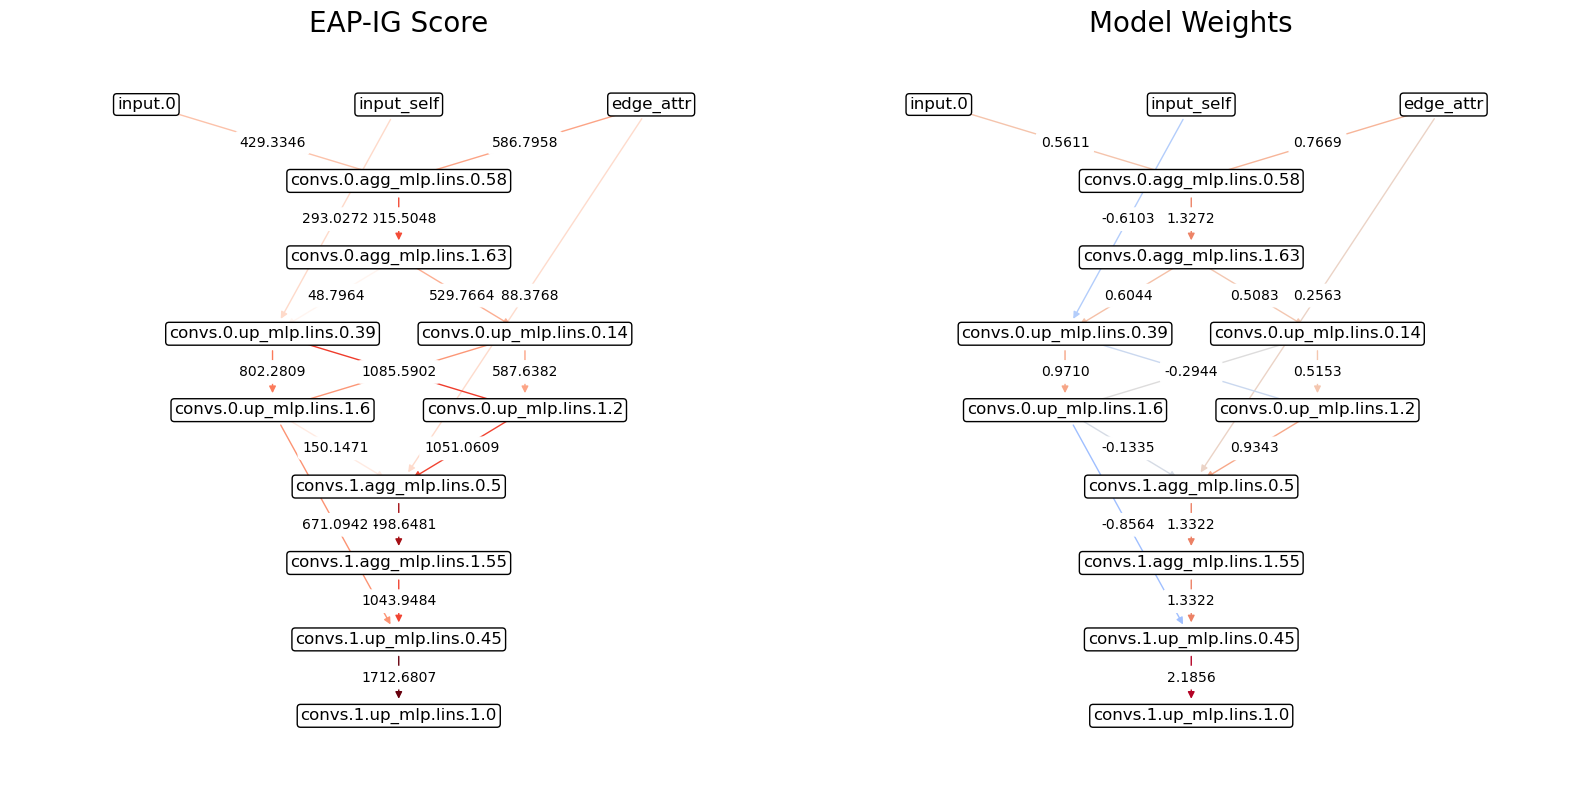

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
c_pos = nx.multipartite_layout(C, subset_key='layer', align='horizontal')
c_pos = {node: (x,-y) for (node, (x,y)) in c_pos.items()}

circuit_edges, circuit_edge_scores = zip(*nx.get_edge_attributes(C,which).items())
nx.draw(C, pos = c_pos, ax=ax[0],
        with_labels=True,
        node_shape="s",
        node_color="none",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2"),
        edge_color=circuit_edge_scores,
        edge_cmap=plt.cm.Reds,
)
edge_labels = dict([((u,v,), f"{d[which]:.4f}") for u,v,d in C.edges(data=True)])
nx.draw_networkx_edge_labels(C, pos = c_pos, ax=ax[0],
                             edge_labels=edge_labels,
                             rotate=False)
ax[0].set_title(f'{which} Score', size=20)

_, circuit_edge_weights = zip(*nx.get_edge_attributes(C,'weight').items())
abs_vmax = abs(max(circuit_edge_weights, key=abs))
nx.draw(C, pos = c_pos, ax=ax[1],
        with_labels=True,
        node_shape="s",
        node_color="none",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2"),
        edge_color=circuit_edge_weights,
        edge_cmap=plt.cm.coolwarm,
        edge_vmax = abs_vmax,
        edge_vmin = -abs_vmax
)
weight_labels = dict([((u,v,), f"{d['weight']:.4f}") for u,v,d in C.edges(data=True)])
nx.draw_networkx_edge_labels(C, pos = c_pos, ax=ax[1],
                             edge_labels=weight_labels,
                             rotate=False)
ax[1].set_title('Model Weights', size=20)

ax[0].margins(x=.2)
ax[1].margins(x=.2)
plt.tight_layout()
plt.savefig('images/bellman_ford_circuit.pdf', bbox_inches='tight')

In [7]:
from tqdm import tqdm
mse_criterion = torch.nn.MSELoss()
score_methods = ['weight', 'weight_grad', 'EAP', 'EAP-IG']
circuit_mse_losses = {score : [] for score in score_methods}
circuit_test_losses = {score : [] for score in score_methods}
actual_node_count = {score : [] for score in score_methods}
actual_edge_count = {score : [] for score in score_methods}
pbar = tqdm(range(20))
for K in pbar:
    for score in score_methods:
        for data in test_loader:
            C_tmp = Circuit(model, G, K=K, key=score)
            out = C_tmp.forward(data).flatten()
            mse_circuit_loss = float(mse_criterion(out[data.reachable], data.y[data.reachable]).detach()) / len(test_data)
            mul_circuit_loss = float(criterion(out[data.reachable], data.y[data.reachable]).detach()) / len(test_data)
            circuit_mse_losses[score].append(mse_circuit_loss)
            circuit_test_losses[score].append(mul_circuit_loss)
            actual_node_count[score].append(C_tmp.number_of_nodes())
            actual_edge_count[score].append(C_tmp.number_of_edges())

100%|██████████| 20/20 [01:23<00:00,  4.19s/it]


Text(0.5, 0, 'Edges')

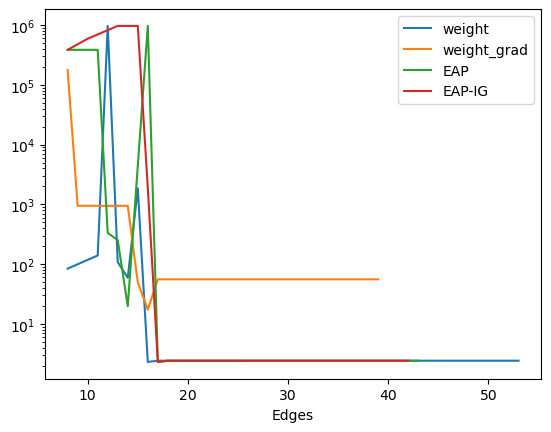

In [8]:
for score in score_methods:
    plt.plot(actual_edge_count[score], circuit_test_losses[score], label=score)

plt.yscale('log')
plt.legend()
plt.xlabel('Edges')

In [9]:
checkpoints = torch.load('model_progress/bellman_ford/model_checkpoints.pt')
circuit_losses = []
for checkpoint in checkpoints:
    model.load_state_dict(checkpoint)
    C.model_state_dict = checkpoint
    for data in test_loader:
        out = C.forward(data).flatten()
        circuit_losses.append(float(criterion(out[data.reachable], data.y[data.reachable]).detach() / num_reachable_test_nodes))

In [10]:
mse_losses = torch.load('model_progress/bellman_ford/mse_losses.pt')
l1_regs = torch.load('model_progress/bellman_ford/l1_regs.pt')
test_losses = torch.load('model_progress/bellman_ford/test_losses.pt')

In [11]:
torch.save(circuit_losses, 'model_progress/bellman_ford/circuit_losses.pt')

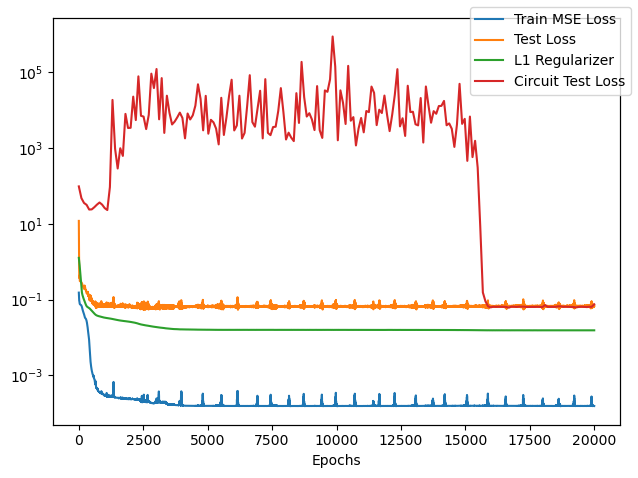

In [12]:
fig, ax = plt.subplots()
ax.plot(mse_losses.detach(), label='Train MSE Loss')
ax.plot(test_losses.detach(), label='Test Loss')
ax.plot((eta * l1_regs).detach(), label='L1 Regularizer')
ax2 = ax.twiny()
ax2.plot(circuit_losses, color='tab:red', label='Circuit Test Loss')
# ax2.plot(circuit_mse_losses['EAP-IG'], color='tab:red', label='Circuit Test Loss')
ax2.set_xticks([])
ax.set_yscale('log')
ax.set_xlabel('Epochs')
fig.legend()
plt.tight_layout()